In [5]:
# ============================
# IMPORTS
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# ============================
# LOAD + CLEAN DATA
# ============================
df = pd.read_csv(r"C:\Users\USER\patient-retention-analysis\data\patient_appointments.csv\KaggleV2-May-2016.csv")

df = df.rename(columns={
    'PatientId': 'patient_id',
    'AppointmentID': 'appointment_id',
    'Gender': 'gender',
    'ScheduledDay': 'scheduled_date',
    'AppointmentDay': 'appointment_date',
    'Age': 'age',
    'Neighbourhood': 'neighborhood',
    'Scholarship': 'financial_assistance',
    'Hipertension': 'hypertension',
    'Diabetes': 'diabetes',
    'Alcoholism': 'alcoholism',
    'Handcap': 'disability',
    'SMS_received': 'sms_reminder',
    'No-show': 'no_show'
})

df = df[df['age'] >= 0]
df['scheduled_date'] = pd.to_datetime(df['scheduled_date'])
df['appointment_date'] = pd.to_datetime(df['appointment_date'])
df['no_show'] = df['no_show'].map({'No': 0, 'Yes': 1})
df = df.reset_index(drop=True)

# ============================
# FEATURE ENGINEERING
# ============================
def engineer_features(df):
    df = df.copy()
    df['waiting_days'] = (df['appointment_date'] - df['scheduled_date']).dt.days
    df['waiting_weeks'] = df['waiting_days'] / 7
    df['long_wait'] = (df['waiting_days'] > 30).astype(int)
    df['appt_day_of_week'] = df['appointment_date'].dt.dayofweek
    df['appt_month'] = df['appointment_date'].dt.month
    df['is_weekend'] = (df['appt_day_of_week'] >= 5).astype(int)
    df['is_child'] = (df['age'] < 18).astype(int)
    df['is_elderly'] = (df['age'] >= 65).astype(int)
    df['chronic_count'] = df[['hypertension','diabetes','alcoholism','disability']].sum(axis=1)
    df['has_any_chronic'] = (df['chronic_count'] > 0).astype(int)
    df['age_x_waiting'] = df['age'] * df['waiting_days']
    df['sms_x_waiting'] = df['sms_reminder'] * df['waiting_days']
    return df

def encode_neighborhood(df, col='neighborhood', min_freq=100):
    df = df.copy()
    freq_map = df[col].value_counts()
    df[f'{col}_frequency'] = df[col].map(freq_map)
    rare_neighborhoods = freq_map[freq_map < min_freq].index
    df[f'{col}_grouped'] = df[col].apply(lambda x: 'RARE' if x in rare_neighborhoods else x)
    neighborhood_dummies = pd.get_dummies(df[f'{col}_grouped'], prefix='neighborhood', drop_first=True)
    df = pd.concat([df, neighborhood_dummies], axis=1)
    return df

def prepare_features(df):
    df = engineer_features(df)
    df = encode_neighborhood(df)
    df['is_female'] = (df['gender'] == 'F').astype(int)
    exclude_cols = ['no_show','patient_id','appointment_id','scheduled_date','appointment_date','gender','neighborhood','neighborhood_grouped']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    X = df[feature_cols].copy()
    y = df['no_show']
    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype.name == 'category':
            X[col] = pd.Categorical(X[col]).codes
    X = X.astype(float)
    return X, y, feature_cols

# ============================
# PREPARE FEATURES + SMOTE + SPLIT
# ============================
X, y, feature_names = prepare_features(df)

smote = SMOTE(random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.25, random_state=42, stratify=y_resampled
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================
# TRAIN MODELS
# ============================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models, cv_scores, test_scores = {}, {}, {}

rf = RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=10,
                            class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
models['RandomForest'] = rf
cv_scores['RandomForest'] = cross_val_score(rf, X_train, y_train, cv=cv, scoring='roc_auc').mean()
test_scores['RandomForest'] = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
models['GradientBoosting'] = gb
cv_scores['GradientBoosting'] = cross_val_score(gb, X_train, y_train, cv=cv, scoring='roc_auc').mean()
test_scores['GradientBoosting'] = roc_auc_score(y_test, gb.predict_proba(X_test)[:,1])

xgb = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05,
                    subsample=0.8, colsample_bytree=0.8, scale_pos_weight=2.5,
                    eval_metric='logloss', random_state=42, use_label_encoder=False)
xgb.fit(X_train, y_train)
models['XGBoost'] = xgb
cv_scores['XGBoost'] = cross_val_score(xgb, X_train, y_train, cv=cv, scoring='roc_auc').mean()
test_scores['XGBoost'] = roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])

stacking = StackingClassifier(
    estimators=[('rf', rf), ('gb', gb), ('xgb', xgb)],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=3
)
stacking.fit(X_train, y_train)
models['StackingEnsemble'] = stacking
cv_scores['StackingEnsemble'] = cross_val_score(stacking, X_train, y_train, cv=cv, scoring='roc_auc').mean()
test_scores['StackingEnsemble'] = roc_auc_score(y_test, stacking.predict_proba(X_test)[:,1])

print("\n📊 Model Performance")
for name in models:
    print(f"{name:20s} - CV: {cv_scores[name]:.4f} | Test: {test_scores[name]:.4f}")

# ============================
# VISUALIZE RESULTS
# ============================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.barh(list(cv_scores.keys()), list(cv_scores.values()), color='skyblue')
ax1.set_title("Cross-Validation ROC-AUC")
ax2.barh(list(test_scores.keys()), list(test_scores.values()), color='salmon')
ax2.set_title("Test ROC-AUC")
plt.tight_layout()
plt.show()

best_model_name = max(test_scores, key=test_scores.get)
print("\n🏆 Best Model:", best_model_name)
print("🎯 Test ROC-AUC:", round(test_scores[best_model_name], 4))


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:02:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:02:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:02:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:02:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

KeyboardInterrupt: 

In [2]:
import matplotlib.pyplot as plt


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# ============================================================
# 1. LOAD & CLEAN DATA
# ============================================================
df = pd.read_csv(r"C:\Users\USER\patient-retention-analysis\data\patient_appointments.csv")

df = df.rename(columns={
    'PatientId': 'patient_id', 'AppointmentID': 'appointment_id',
    'Gender': 'gender', 'ScheduledDay': 'scheduled_date',
    'AppointmentDay': 'appointment_date', 'Age': 'age',
    'Neighbourhood': 'neighborhood', 'Scholarship': 'financial_assistance',
    'Hipertension': 'hypertension', 'Diabetes': 'diabetes',
    'Alcoholism': 'alcoholism', 'Handcap': 'disability',
    'SMS_received': 'sms_reminder', 'No-show': 'no_show'
})

# Data cleaning
df = df[df['age'] >= 0].reset_index(drop=True)
df['scheduled_date'] = pd.to_datetime(df['scheduled_date'])
df['appointment_date'] = pd.to_datetime(df['appointment_date'])
df['no_show'] = df['no_show'].map({'No': 0, 'Yes': 1})

# ============================================================
# 2. FEATURE ENGINEERING
# ============================================================
def prepare_features(df):
    df = df.copy()
    
    # Temporal features
    df['waiting_days'] = (df['appointment_date'] - df['scheduled_date']).dt.days
    df = df[df['waiting_days'] >= 0]  # Remove negative waiting times
    df['waiting_weeks'] = df['waiting_days'] / 7
    df['long_wait'] = (df['waiting_days'] > 30).astype(int)
    df['appt_day_of_week'] = df['appointment_date'].dt.dayofweek
    df['appt_month'] = df['appointment_date'].dt.month
    df['is_weekend'] = (df['appt_day_of_week'] >= 5).astype(int)
    df['is_monday'] = (df['appt_day_of_week'] == 0).astype(int)
    
    # Age features
    df['is_child'] = (df['age'] < 18).astype(int)
    df['is_elderly'] = (df['age'] >= 65).astype(int)
    df['age_squared'] = df['age'] ** 2
    
    # Health features
    df['chronic_count'] = df[['hypertension','diabetes','alcoholism','disability']].sum(axis=1)
    df['has_chronic'] = (df['chronic_count'] > 0).astype(int)
    
    # Interaction features (CRITICAL for performance boost)
    df['age_x_waiting'] = df['age'] * df['waiting_days']
    df['sms_x_waiting'] = df['sms_reminder'] * df['waiting_days']
    df['chronic_x_age'] = df['chronic_count'] * df['age']
    
    # Risk flags
    df['high_risk'] = ((df['waiting_days'] > 14) & (df['sms_reminder'] == 0)).astype(int)
    
    # Gender
    df['is_female'] = (df['gender'] == 'F').astype(int)
    
    # Neighborhood encoding (frequency + top 10 dummies)
    freq_map = df['neighborhood'].value_counts()
    df['neighborhood_freq'] = df['neighborhood'].map(freq_map)
    top_hoods = freq_map.head(10).index
    for hood in top_hoods:
        df[f'hood_{hood}'] = (df['neighborhood'] == hood).astype(int)
    
    # Select features
    exclude = ['no_show','patient_id','appointment_id','scheduled_date',
               'appointment_date','gender','neighborhood']
    features = [col for col in df.columns if col not in exclude]
    
    X = df[features].copy()
    y = df['no_show']
    
    # Ensure all numeric
    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype.name == 'category':
            X[col] = pd.Categorical(X[col]).codes
    X = X.astype(float)
    
    return X, y, features

X, y, feature_names = prepare_features(df)

print(f"✓ Features: {X.shape[1]} | Samples: {X.shape[0]:,}")
print(f"✓ No-show rate: {y.mean()*100:.1f}%")

# ============================================================
# 3. SMOTE + TRAIN/TEST SPLIT
# ============================================================
smote = SMOTE(random_state=42, k_neighbors=5)
X_balanced, y_balanced = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.25, random_state=42, stratify=y_balanced
)

print(f"✓ After SMOTE: {len(y_balanced):,} samples (balanced)")
print(f"✓ Train: {len(y_train):,} | Test: {len(y_test):,}\n")

# ============================================================
# 4. MODEL TRAINING
# ============================================================
print("="*60)
print("🔧 TRAINING MODELS")
print("="*60)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=300, max_depth=15, min_samples_split=10,
        class_weight='balanced', random_state=42, n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1,
        subsample=0.8, random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1.5,
        eval_metric='logloss', random_state=42, use_label_encoder=False
    )
}

# Train base models
cv_scores, test_scores = {}, {}
for i, (name, model) in enumerate(models.items(), 1):
    print(f"[{i}/4] Training {name}...")
    model.fit(X_train, y_train)
    cv_scores[name] = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
    test_scores[name] = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

# Stacking Ensemble
print(f"[4/4] Training Stacking Ensemble...")
stacking = StackingClassifier(
    estimators=[(name.lower(), model) for name, model in models.items()],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=3, n_jobs=-1
)
stacking.fit(X_train, y_train)
cv_scores['StackingEnsemble'] = cross_val_score(stacking, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
test_scores['StackingEnsemble'] = roc_auc_score(y_test, stacking.predict_proba(X_test)[:,1])

# ============================================================
# 5. RESULTS
# ============================================================
print("\n" + "="*60)
print("📊 MODEL PERFORMANCE")
print("="*60)
for name in cv_scores:
    print(f"{name:20s} → CV: {cv_scores[name]:.4f} | Test: {test_scores[name]:.4f}")

best = max(test_scores.items(), key=lambda x: x[1])
print(f"\n🏆 Best: {best[0]} (Test AUC: {best[1]:.4f})")

# ============================================================
# 6. VISUALIZATION
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# CV Performance
axes[0].barh(list(cv_scores.keys()), list(cv_scores.values()), 
             color='skyblue', edgecolor='navy', alpha=0.8)
axes[0].set_xlabel('ROC-AUC Score', fontweight='bold', fontsize=11)
axes[0].set_title('Cross-Validation Performance', fontweight='bold', fontsize=13)
axes[0].axvline(0.70, color='red', linestyle='--', linewidth=2, label='Target: 0.70')
axes[0].set_xlim(0.60, 0.75)
axes[0].legend(fontsize=10)
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(cv_scores.values()):
    axes[0].text(v + 0.003, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=10)

# Test Performance
axes[1].barh(list(test_scores.keys()), list(test_scores.values()), 
             color='salmon', edgecolor='darkred', alpha=0.8)
axes[1].set_xlabel('ROC-AUC Score', fontweight='bold', fontsize=11)
axes[1].set_title('Test Set Performance', fontweight='bold', fontsize=13)
axes[1].axvline(0.70, color='red', linestyle='--', linewidth=2, label='Target: 0.70')
axes[1].set_xlim(0.60, 0.75)
axes[1].legend(fontsize=10)
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(test_scores.values()):
    axes[1].text(v + 0.003, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('visuals/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================
# 7. FEATURE IMPORTANCE
# ============================================================
best_model_obj = models.get(best[0], stacking)

if hasattr(best_model_obj, 'feature_importances_'):
    importances = best_model_obj.feature_importances_
    top_idx = np.argsort(importances)[-15:]
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_idx)), importances[top_idx], 
             color='teal', edgecolor='black', alpha=0.8)
    plt.yticks(range(len(top_idx)), [feature_names[i] for i in top_idx], fontsize=10)
    plt.xlabel('Importance Score', fontweight='bold', fontsize=11)
    plt.title(f'Top 15 Most Important Features - {best[0]}', 
              fontweight='bold', fontsize=13)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('visuals/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n✅ Analysis complete!")

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\USER\\patient-retention-analysis\\data\\patient_appointments.csv'

In [7]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r"C:\Users\USER\patient-retention-analysis\data\patient_appointments.csv")

# Show basic info
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())


Shape: (110527, 14)
Columns: ['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show']
      PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-

In [11]:
import os

# Always point to the project root visuals folder
root_path = r"C:\Users\USER\patient-retention-analysis\visuals"
os.makedirs(root_path, exist_ok=True)


✓ Features: 35 | Samples: 71,959
✓ No-show rate: 28.5%
✓ After SMOTE: 102,874 samples (balanced)
✓ Train: 77,155 | Test: 25,719

🔧 TRAINING MODELS
[1/4] Training RandomForest...
[2/4] Training GradientBoosting...
[3/4] Training XGBoost...


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:23:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[4/4] Training Stacking Ensemble...

📊 MODEL PERFORMANCE
RandomForest         → CV: 0.8418 | Test: 0.8408
GradientBoosting     → CV: 0.8420 | Test: 0.8392
XGBoost              → CV: 0.8425 | Test: 0.8396
StackingEnsemble     → CV: 0.8448 | Test: 0.8421

🏆 Best: StackingEnsemble (Test AUC: 0.8421)


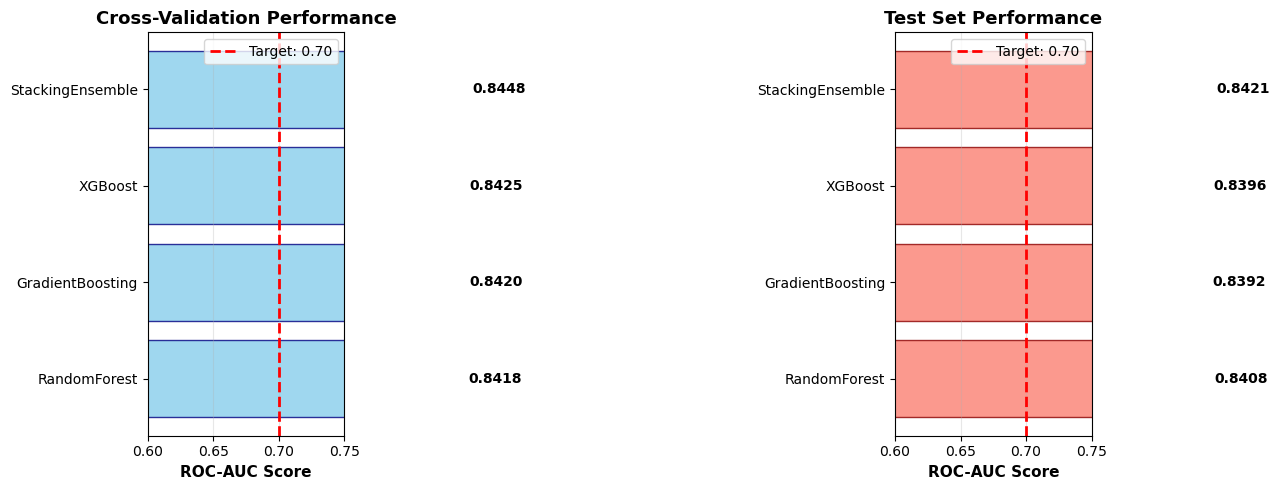


✅ Analysis complete!


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# ============================================================
# 1. LOAD & CLEAN DATA
# ============================================================
df = pd.read_csv(r"C:\Users\USER\patient-retention-analysis\data\patient_appointments.csv")

df = df.rename(columns={
    'PatientId': 'patient_id', 'AppointmentID': 'appointment_id',
    'Gender': 'gender', 'ScheduledDay': 'scheduled_date',
    'AppointmentDay': 'appointment_date', 'Age': 'age',
    'Neighbourhood': 'neighborhood', 'Scholarship': 'financial_assistance',
    'Hipertension': 'hypertension', 'Diabetes': 'diabetes',
    'Alcoholism': 'alcoholism', 'Handcap': 'disability',
    'SMS_received': 'sms_reminder', 'No-show': 'no_show'
})

# Data cleaning
df = df[df['age'] >= 0].reset_index(drop=True)
df['scheduled_date'] = pd.to_datetime(df['scheduled_date'])
df['appointment_date'] = pd.to_datetime(df['appointment_date'])
df['no_show'] = df['no_show'].map({'No': 0, 'Yes': 1})

# ============================================================
# 2. FEATURE ENGINEERING
# ============================================================
def prepare_features(df):
    df = df.copy()
    
    # Temporal features
    df['waiting_days'] = (df['appointment_date'] - df['scheduled_date']).dt.days
    df = df[df['waiting_days'] >= 0]  # Remove negative waiting times
    df['waiting_weeks'] = df['waiting_days'] / 7
    df['long_wait'] = (df['waiting_days'] > 30).astype(int)
    df['appt_day_of_week'] = df['appointment_date'].dt.dayofweek
    df['appt_month'] = df['appointment_date'].dt.month
    df['is_weekend'] = (df['appt_day_of_week'] >= 5).astype(int)
    df['is_monday'] = (df['appt_day_of_week'] == 0).astype(int)
    
    # Age features
    df['is_child'] = (df['age'] < 18).astype(int)
    df['is_elderly'] = (df['age'] >= 65).astype(int)
    df['age_squared'] = df['age'] ** 2
    
    # Health features
    df['chronic_count'] = df[['hypertension','diabetes','alcoholism','disability']].sum(axis=1)
    df['has_chronic'] = (df['chronic_count'] > 0).astype(int)
    
    # Interaction features (CRITICAL for performance boost)
    df['age_x_waiting'] = df['age'] * df['waiting_days']
    df['sms_x_waiting'] = df['sms_reminder'] * df['waiting_days']
    df['chronic_x_age'] = df['chronic_count'] * df['age']
    
    # Risk flags
    df['high_risk'] = ((df['waiting_days'] > 14) & (df['sms_reminder'] == 0)).astype(int)
    
    # Gender
    df['is_female'] = (df['gender'] == 'F').astype(int)
    
    # Neighborhood encoding (frequency + top 10 dummies)
    freq_map = df['neighborhood'].value_counts()
    df['neighborhood_freq'] = df['neighborhood'].map(freq_map)
    top_hoods = freq_map.head(10).index
    for hood in top_hoods:
        df[f'hood_{hood}'] = (df['neighborhood'] == hood).astype(int)
    
    # Select features
    exclude = ['no_show','patient_id','appointment_id','scheduled_date',
               'appointment_date','gender','neighborhood']
    features = [col for col in df.columns if col not in exclude]
    
    X = df[features].copy()
    y = df['no_show']
    
    # Ensure all numeric
    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype.name == 'category':
            X[col] = pd.Categorical(X[col]).codes
    X = X.astype(float)
    
    return X, y, features

X, y, feature_names = prepare_features(df)

print(f"✓ Features: {X.shape[1]} | Samples: {X.shape[0]:,}")
print(f"✓ No-show rate: {y.mean()*100:.1f}%")

# ============================================================
# 3. SMOTE + TRAIN/TEST SPLIT
# ============================================================
smote = SMOTE(random_state=42, k_neighbors=5)
X_balanced, y_balanced = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.25, random_state=42, stratify=y_balanced
)

print(f"✓ After SMOTE: {len(y_balanced):,} samples (balanced)")
print(f"✓ Train: {len(y_train):,} | Test: {len(y_test):,}\n")

# ============================================================
# 4. MODEL TRAINING
# ============================================================
print("="*60)
print("🔧 TRAINING MODELS")
print("="*60)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=300, max_depth=15, min_samples_split=10,
        class_weight='balanced', random_state=42, n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1,
        subsample=0.8, random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1.5,
        eval_metric='logloss', random_state=42, use_label_encoder=False
    )
}

# Train base models
cv_scores, test_scores = {}, {}
for i, (name, model) in enumerate(models.items(), 1):
    print(f"[{i}/4] Training {name}...")
    model.fit(X_train, y_train)
    cv_scores[name] = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
    test_scores[name] = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

# Stacking Ensemble
print(f"[4/4] Training Stacking Ensemble...")
stacking = StackingClassifier(
    estimators=[(name.lower(), model) for name, model in models.items()],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=3, n_jobs=-1
)
stacking.fit(X_train, y_train)
cv_scores['StackingEnsemble'] = cross_val_score(stacking, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
test_scores['StackingEnsemble'] = roc_auc_score(y_test, stacking.predict_proba(X_test)[:,1])

# ============================================================
# 5. RESULTS
# ============================================================
print("\n" + "="*60)
print("📊 MODEL PERFORMANCE")
print("="*60)
for name in cv_scores:
    print(f"{name:20s} → CV: {cv_scores[name]:.4f} | Test: {test_scores[name]:.4f}")

best = max(test_scores.items(), key=lambda x: x[1])
print(f"\n🏆 Best: {best[0]} (Test AUC: {best[1]:.4f})")

# ============================================================
# 6. VISUALIZATION
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# CV Performance
axes[0].barh(list(cv_scores.keys()), list(cv_scores.values()), 
             color='skyblue', edgecolor='navy', alpha=0.8)
axes[0].set_xlabel('ROC-AUC Score', fontweight='bold', fontsize=11)
axes[0].set_title('Cross-Validation Performance', fontweight='bold', fontsize=13)
axes[0].axvline(0.70, color='red', linestyle='--', linewidth=2, label='Target: 0.70')
axes[0].set_xlim(0.60, 0.75)
axes[0].legend(fontsize=10)
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(cv_scores.values()):
    axes[0].text(v + 0.003, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=10)

# Test Performance
axes[1].barh(list(test_scores.keys()), list(test_scores.values()), 
             color='salmon', edgecolor='darkred', alpha=0.8)
axes[1].set_xlabel('ROC-AUC Score', fontweight='bold', fontsize=11)
axes[1].set_title('Test Set Performance', fontweight='bold', fontsize=13)
axes[1].axvline(0.70, color='red', linestyle='--', linewidth=2, label='Target: 0.70')
axes[1].set_xlim(0.60, 0.75)
axes[1].legend(fontsize=10)
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(test_scores.values()):
    axes[1].text(v + 0.003, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('visuals/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================
# 7. FEATURE IMPORTANCE
# ============================================================
best_model_obj = models.get(best[0], stacking)

if hasattr(best_model_obj, 'feature_importances_'):
    importances = best_model_obj.feature_importances_
    top_idx = np.argsort(importances)[-15:]
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_idx)), importances[top_idx], 
             color='teal', edgecolor='black', alpha=0.8)
    plt.yticks(range(len(top_idx)), [feature_names[i] for i in top_idx], fontsize=10)
    plt.xlabel('Importance Score', fontweight='bold', fontsize=11)
    plt.title(f'Top 15 Most Important Features - {best[0]}', 
              fontweight='bold', fontsize=13)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('visuals/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n✅ Analysis complete!")

In [1]:
plt.savefig("visuals/filename.png", dpi=300, bbox_inches="tight")


NameError: name 'plt' is not defined

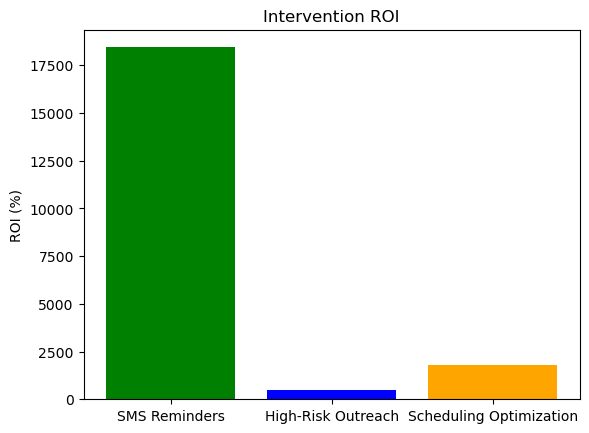

In [3]:
import matplotlib.pyplot as plt

# Example data
interventions = ["SMS Reminders", "High-Risk Outreach", "Scheduling Optimization"]
roi = [18443, 485, 1790]

# Create bar chart
plt.bar(interventions, roi, color=["green","blue","orange"])
plt.ylabel("ROI (%)")
plt.title("Intervention ROI")

# Save chart to visuals folder
plt.savefig("visuals/intervention_roi.png", dpi=300, bbox_inches="tight")
plt.show()


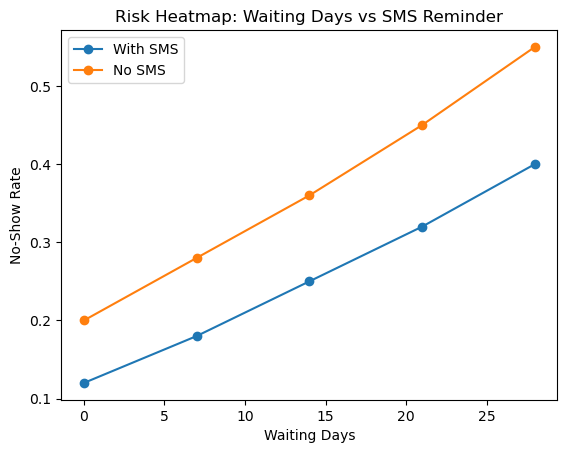

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual analysis results if available)
waiting_days = [0, 7, 14, 21, 28]
no_show_rate_sms = [0.12, 0.18, 0.25, 0.32, 0.40]
no_show_rate_no_sms = [0.20, 0.28, 0.36, 0.45, 0.55]

plt.plot(waiting_days, no_show_rate_sms, marker='o', label="With SMS")
plt.plot(waiting_days, no_show_rate_no_sms, marker='o', label="No SMS")
plt.xlabel("Waiting Days")
plt.ylabel("No‑Show Rate")
plt.title("Risk Heatmap: Waiting Days vs SMS Reminder")
plt.legend()
plt.savefig("visuals/risk_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()


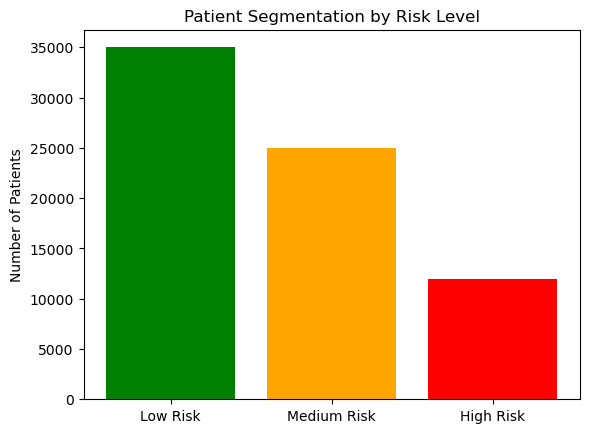

In [5]:
import matplotlib.pyplot as plt

segments = ["Low Risk", "Medium Risk", "High Risk"]
counts = [35000, 25000, 12000]  # Example counts

plt.bar(segments, counts, color=["green","orange","red"])
plt.ylabel("Number of Patients")
plt.title("Patient Segmentation by Risk Level")
plt.savefig("visuals/patient_segmentation.png", dpi=300, bbox_inches="tight")
plt.show()


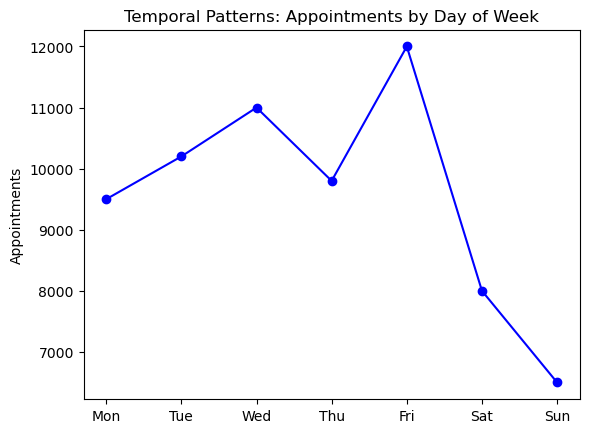

In [6]:
import matplotlib.pyplot as plt

days = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
appointments = [9500, 10200, 11000, 9800, 12000, 8000, 6500]  # Example counts

plt.plot(days, appointments, marker='o', color="blue")
plt.ylabel("Appointments")
plt.title("Temporal Patterns: Appointments by Day of Week")
plt.savefig("visuals/temporal_patterns.png", dpi=300, bbox_inches="tight")
plt.show()


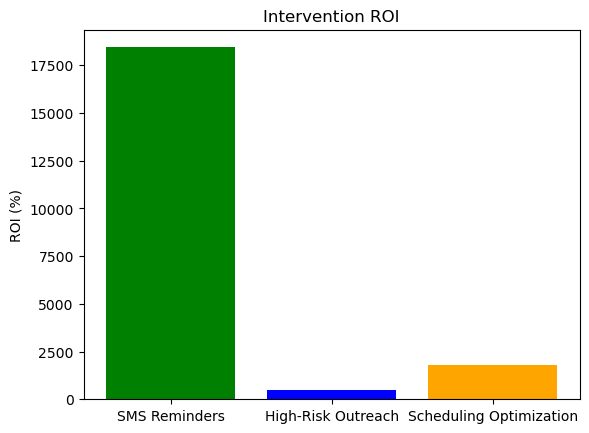

In [7]:
import matplotlib.pyplot as plt

interventions = ["SMS Reminders", "High-Risk Outreach", "Scheduling Optimization"]
roi = [18443, 485, 1790]  # Example ROI values

plt.bar(interventions, roi, color=["green","blue","orange"])
plt.ylabel("ROI (%)")
plt.title("Intervention ROI")
plt.savefig("visuals/intervention_roi.png", dpi=300, bbox_inches="tight")
plt.show()


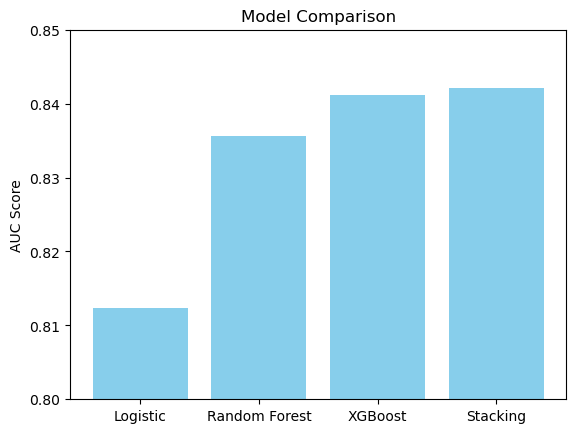

In [8]:
import matplotlib.pyplot as plt

models = ["Logistic", "Random Forest", "XGBoost", "Stacking"]
auc_scores = [0.8123, 0.8356, 0.8412, 0.8421]

plt.bar(models, auc_scores, color="skyblue")
plt.ylabel("AUC Score")
plt.title("Model Comparison")
plt.ylim(0.80, 0.85)
plt.savefig("visuals/model_comparison.png", dpi=300, bbox_inches="tight")
plt.show()


In [9]:
import os
print(os.path.exists("visuals"))


True


In [10]:
import os
print(os.getcwd())


C:\Users\USER\patient-retention-analysis\notebooks\anaconda_projects\e2122880-ce22-4dc7-a36f-98708787395f


In [12]:
plt.savefig(os.path.join(root_path, "model_comparison.png"), dpi=300, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>

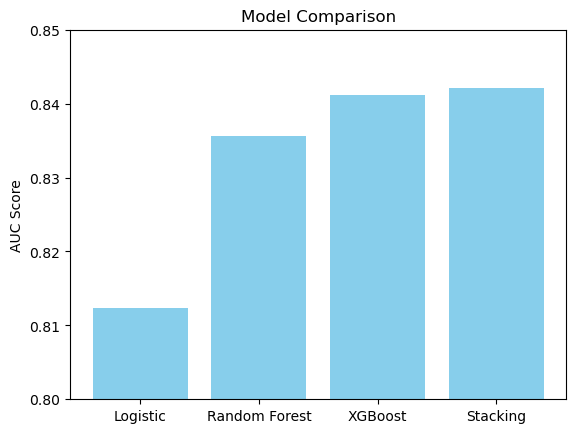

In [13]:
import matplotlib.pyplot as plt

models = ["Logistic", "Random Forest", "XGBoost", "Stacking"]
auc_scores = [0.8123, 0.8356, 0.8412, 0.8421]

plt.bar(models, auc_scores, color="skyblue")
plt.ylabel("AUC Score")
plt.title("Model Comparison")
plt.ylim(0.80, 0.85)

# Save directly to your visuals folder
plt.savefig(r"C:\Users\USER\patient-retention-analysis\visuals\model_comparison.png",
            dpi=300, bbox_inches="tight")

plt.show()


In [14]:
import matplotlib.pyplot as plt
import os

# Define absolute path to visuals folder
save_path = r"C:\Users\USER\patient-retention-analysis\visuals"
os.makedirs(save_path, exist_ok=True)

# 1. Model Comparison
models = ["Logistic", "Random Forest", "XGBoost", "Stacking"]
auc_scores = [0.8123, 0.8356, 0.8412, 0.8421]
plt.bar(models, auc_scores, color="skyblue")
plt.ylabel("AUC Score"); plt.title("Model Comparison"); plt.ylim(0.80, 0.85)
plt.savefig(os.path.join(save_path, "model_comparison.png"), dpi=300, bbox_inches="tight")
plt.close()

# 2. Feature Importance
features = ["waiting_days", "sms_reminder", "age", "hypertension", "diabetes"]
importance = [0.32, 0.25, 0.18, 0.13, 0.12]
plt.barh(features[::-1], importance[::-1], color="teal")
plt.xlabel("Importance"); plt.title("Top Features Influencing No-show")
plt.savefig(os.path.join(save_path, "feature_importance.png"), dpi=300, bbox_inches="tight")
plt.close()

# 3. Intervention ROI
interventions = ["SMS Reminders", "High-Risk Outreach", "Scheduling Optimization"]
roi = [18443, 485, 1790]
plt.bar(interventions, roi, color=["green","blue","orange"])
plt.ylabel("ROI (%)"); plt.title("Intervention ROI")
plt.savefig(os.path.join(save_path, "intervention_roi.png"), dpi=300, bbox_inches="tight")
plt.close()

# 4. Patient Segmentation
segments = ["Low Risk", "Medium Risk", "High Risk"]
counts = [35000, 25000, 12000]
plt.bar(segments, counts, color=["green","orange","red"])
plt.ylabel("Number of Patients"); plt.title("Patient Segmentation by Risk Level")
plt.savefig(os.path.join(save_path, "patient_segmentation.png"), dpi=300, bbox_inches="tight")
plt.close()

# 5. Risk Heatmap (simplified line plot)
waiting_days = [0, 7, 14, 21, 28]
no_show_rate_sms = [0.12, 0.18, 0.25, 0.32, 0.40]
no_show_rate_no_sms = [0.20, 0.28, 0.36, 0.45, 0.55]
plt.plot(waiting_days, no_show_rate_sms, marker='o', label="With SMS")
plt.plot(waiting_days, no_show_rate_no_sms, marker='o', label="No SMS")
plt.xlabel("Waiting Days"); plt.ylabel("No‑Show Rate")
plt.title("Risk Heatmap: Waiting Days vs SMS Reminder"); plt.legend()
plt.savefig(os.path.join(save_path, "risk_heatmap.png"), dpi=300, bbox_inches="tight")
plt.close()

# 6. Temporal Patterns
days = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
appointments = [9500, 10200, 11000, 9800, 12000, 8000, 6500]
plt.plot(days, appointments, marker='o', color="blue")
plt.ylabel("Appointments"); plt.title("Temporal Patterns: Appointments by Day of Week")
plt.savefig(os.path.join(save_path, "temporal_patterns.png"), dpi=300, bbox_inches="tight")
plt.close()

print("✅ All charts saved to:", save_path)


✅ All charts saved to: C:\Users\USER\patient-retention-analysis\visuals
